## **CREATING CNN MODEL AND TUNING WITH KERAS TUNER**

### Imporitng Libraries:

In [ ]:
# installing keras tuner packages.... 
!pip install keras_tuner --upgrade

     |████████████████████████████████| 98 kB 3.0 MB/s 


In [ ]:
# import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras_tuner import RandomSearch
from keras.preprocessing import image

In [ ]:
# importing dataset from keras library
data = keras.datasets.fashion_mnist

In [ ]:
# splitting data from the dataset
(X_train, y_train), (X_test, y_test) = data.load_data()

4431872/4422102 [==============================] - 0s 0us/step


#### **Each training and test example is assigned to one of the following labels:**

    0 T-shirt/top
    1 Trouser
    2 Pullover
    3 Dress
    4 Coat
    5 Sandal
    6 Shirt
    7 Sneaker
    8 Bag
    9 Ankle boot

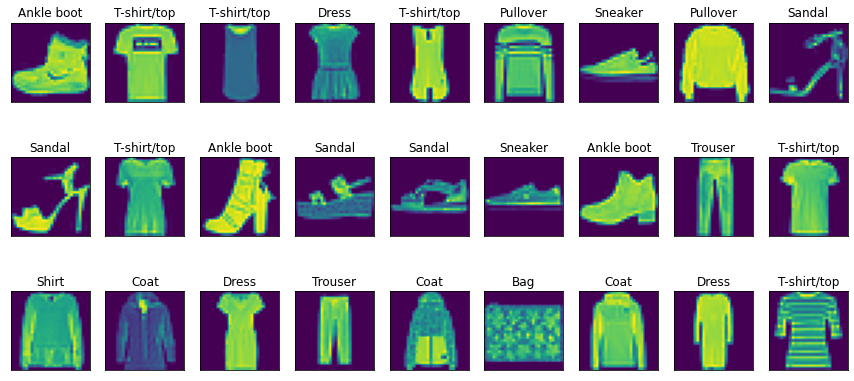

In [ ]:
# plotting the first 27 images...
class_labels = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

# adjust the figure size
plt.figure(figsize=(15,7))
for i in range(27):
  plt.subplot(3, 9, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(X_train[i].reshape(28, 28))
  label_index = int(y_train[i])
  plt.title(class_labels[label_index])
plt.show()

In [ ]:
# just for my use, convert y value into dataframe for finding value counts
y = pd.DataFrame(y_train)
y.value_counts()  # there are 10 classes

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
dtype: int64

In [ ]:
# shape of training data
X_train.shape

(60000, 28, 28)

### **Preprocessing for Image Dataset:**

In [ ]:
X_train = image.img_to_array(X_train)
X_test = image.img_to_array(X_test)

# convert image into numpy array as type of float 32
X_train = np.array(X_train)   
X_test = np.array(X_test)

# preprocessing image by dividing into 255.0 value
X_train = X_train/255.0      
X_test = X_test/255.0


In [ ]:
# reshape the train & test dataset
X_train = X_train.reshape(len(X_train), 28, 28, 1)
X_test = X_test.reshape(len(X_test), 28, 28, 1)

### **Model Building:**

In [ ]:
# create a function for Model building
def create_model(hp):
  # initializing the model
  model = Sequential(
      # Creating 1st Conv2D layer
      [Conv2D(filters=hp.Int("conv_1_filter", min_value=16, max_value=128, step=16),
              kernel_size=hp.Choice("conv_1_kernel", values=[3,5]),
              activation='relu',
              kernel_initializer='he_normal',
              input_shape=(28, 28, 1)),
      
      # Adding maxpooling layer to get max value within a matrix
      MaxPooling2D(pool_size=(2,2)),
       
      # Creating 2nd Conv2D layer
      Conv2D(filters=hp.Int("conv_2_filter", min_value=16, max_value=128, step=16),
             kernel_initializer='he_normal',
             kernel_size=hp.Choice("conv_2_kernel", values=[3,5]),
             activation='relu',
             input_shape=(28, 28, 1)),

      # Adding maxpooling layer to get max value within a matrix
      MaxPooling2D(pool_size=(2,2)),

      # Adding Flatten layer 
      Flatten(),

      # Creating 1st hidden layer 
      Dense(units=hp.Int("layer_1_units", min_value=32, max_value=512, step=32),
            activation='relu',
            kernel_initializer='he_normal'),
      
      # Creating 2nd hidden layer 
      Dense(units=hp.Int("layer_2_units", min_value=32, max_value=512, step=32),
            activation='relu',
            kernel_initializer='he_normal'),
       
      # Creating output layer
      Dense(units=10, activation='softmax')
       ])
  
  # Finaly compile the model...
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model


### **Tuning our Model with Keras Tuner:**

In [ ]:
# using RandomSearch from kera tuner library
tuner = RandomSearch(create_model, objective='val_accuracy', max_trials=5, directory='log', project_name='CNN')
# search the best model by fitting the dataset
tuner.search(X_train, y_train, epochs=5, validation_split=0.1)

Trial 5 Complete [00h 00m 45s]
val_accuracy: 0.8726666569709778

Best val_accuracy So Far: 0.909166693687439
Total elapsed time: 00h 06m 19s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# creating a varible to store best model
model = tuner.get_best_models(num_models=1)[0]   

In [ ]:
# summary of our model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 48)        1248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 48)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         153728    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 352)               721248    
_________________________________________________________________
dense_1 (Dense)              (None, 224)               7

In [ ]:
# fitting the dataset with the tuned model and validating our model using test data
Model = model.fit(X_train, y_train, epochs=10, validation_split=0.3, validation_data=(X_test, y_test))

Epoch 1/10
1313/1313 [==============================] - 12s 9ms/step - loss: 0.1541 - accuracy: 0.9418 - val_loss: 0.1977 - val_accuracy: 0.9295
Epoch 2/10
1313/1313 [==============================] - 11s 8ms/step - loss: 0.1292 - accuracy: 0.9507 - val_loss: 0.2624 - val_accuracy: 0.9177
Epoch 3/10
1313/1313 [==============================] - 11s 8ms/step - loss: 0.1141 - accuracy: 0.9579 - val_loss: 0.2058 - val_accuracy: 0.9295
Epoch 4/10
1313/1313 [==============================] - 11s 9ms/step - loss: 0.0969 - accuracy: 0.9630 - val_loss: 0.2516 - val_accuracy: 0.9218
Epoch 5/10
1313/1313 [==============================] - 11s 8ms/step - loss: 0.0865 - accuracy: 0.9682 - val_loss: 0.2595 - val_accuracy: 0.9238
Epoch 6/10
1313/1313 [==============================] - 11s 8ms/step - loss: 0.0747 - accuracy: 0.9726 - val_loss: 0.2597 - val_accuracy: 0.9258
Epoch 7/10
1313/1313 [==============================] - 12s 9ms/step - loss: 0.0680 - accuracy: 0.9747 - val_loss: 0.2688 - val_ac

In [ ]:
# getting history of our model in dictionary by getting keys... 
print(Model.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


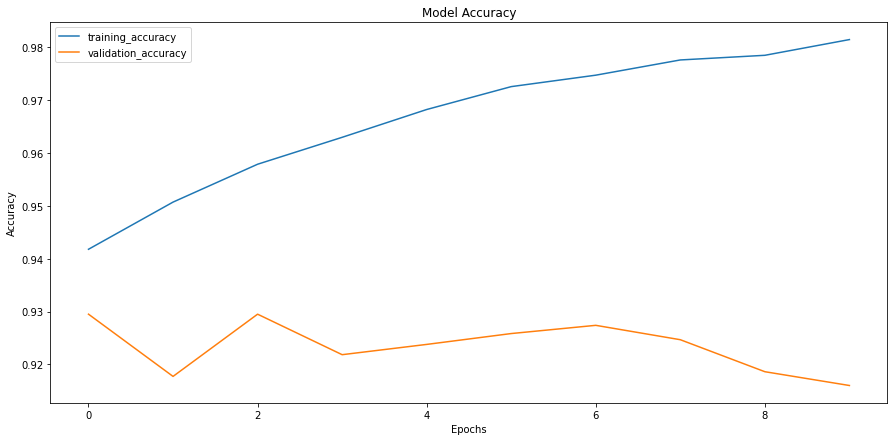

In [ ]:
# Evaluating the model accuracy
plt.figure(figsize=(15,7))
plt.plot(Model.history['accuracy'])
plt.plot(Model.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['training_accuracy', 'validation_accuracy'])
plt.show()

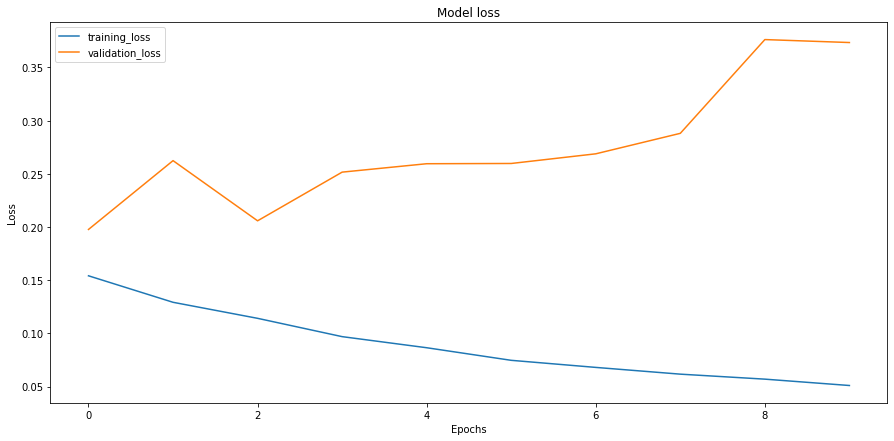

In [ ]:
# Evaluating the Loss
plt.figure(figsize=(15,7))
plt.plot(Model.history['loss'])
plt.plot(Model.history['val_loss'])
plt.title("Model loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['training_loss', 'validation_loss'])
plt.show()